<a href="https://colab.research.google.com/github/felix7974/-/blob/main/4_2_nhiss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4-2. 국가건강검진 혈액검사 데이터

- Draft written by Seunghun Shin, revised by Hyeonseung Im
- 다운로드 링크 : https://nhiss.nhis.or.kr/bd/ab/bdabf006cv.do

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras

import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print(tf.__version__)

2.11.0


## 탐색적 데이터 분석석

In [ ]:
df = pd.read_csv('/content/국가건강검진_혈액검사데이터.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   SEX     1000000 non-null  int64  
 1   AGE_G   1000000 non-null  int64  
 2   HGB     1000000 non-null  float64
 3   TCHOL   1000000 non-null  int64  
 4   TG      1000000 non-null  int64  
 5   HDL     1000000 non-null  int64  
 6   ANE     1000000 non-null  int64  
 7   IHD     1000000 non-null  int64  
 8   STK     1000000 non-null  int64  
dtypes: float64(1), int64(8)
memory usage: 68.7 MB


In [ ]:
df.head()

,SEX,AGE_G,HGB,TCHOL,TG,HDL,ANE,IHD,STK
0,1,1,15.5,139,112,54,0,0,0
1,1,1,16.2,204,105,55,0,0,0
2,1,1,16.4,181,83,67,0,0,0
3,1,1,16.1,147,45,56,0,0,0
4,1,1,15.3,148,70,57,0,0,0


In [ ]:
pd.options.display.float_format = '{:.2f}'.format
df.describe()

,SEX,AGE_G,HGB,TCHOL,TG,HDL,ANE,IHD,STK
count,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00,1000000.00
mean,1.49,14.04,14.03,194.47,129.74,55.56,0.08,0.07,0.06
std,0.50,6.96,1.63,37.18,93.50,14.24,0.27,0.26,0.24
min,1.00,1.00,6.30,90.00,20.00,19.00,0.00,0.00,0.00
25%,1.00,9.00,13.00,169.00,72.00,45.00,0.00,0.00,0.00
50%,1.00,14.00,14.00,192.00,105.00,54.00,0.00,0.00,0.00
75%,2.00,19.00,15.20,218.00,157.00,64.00,0.00,0.00,0.00
max,2.00,27.00,19.00,380.00,1503.00,131.00,1.00,1.00,1.00


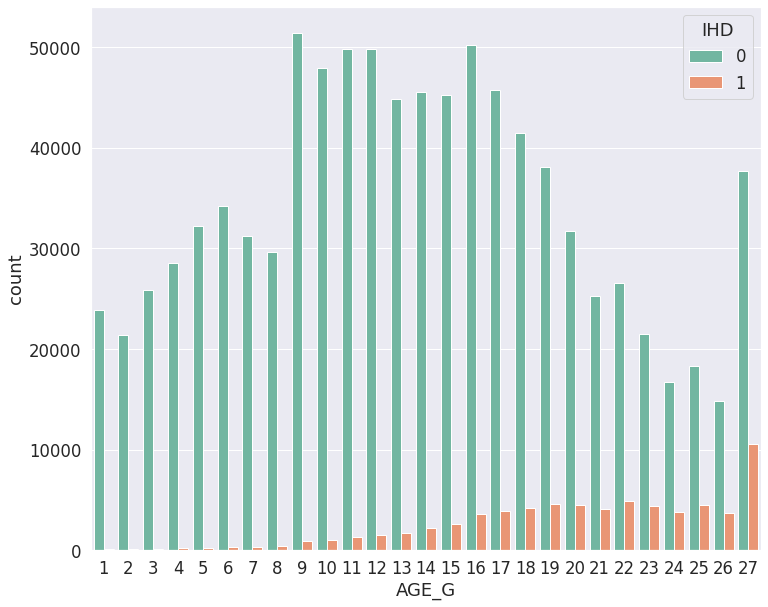

In [ ]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 10
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

sns.set(font_scale=1.5)
sns.countplot(x='AGE_G', hue='IHD', data = df, palette="Set2")

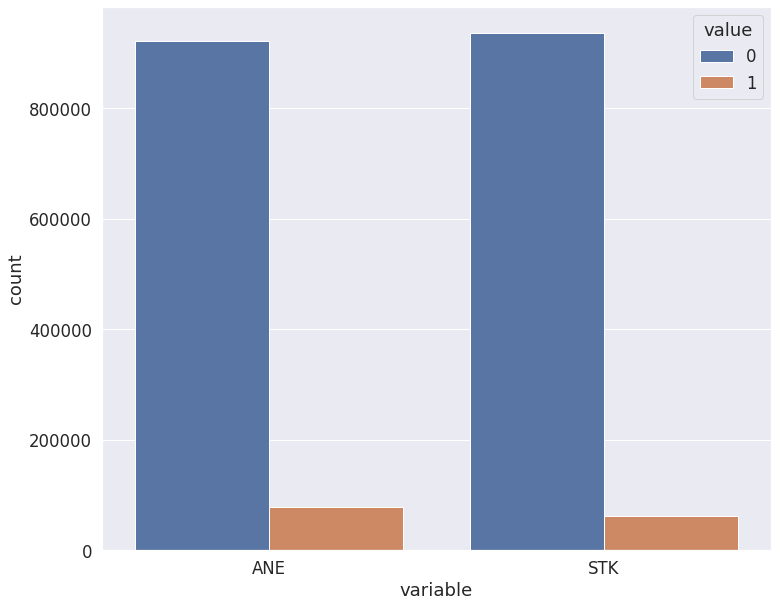

In [ ]:
df_cat = df.loc[:, ['ANE', 'STK']]
sns.countplot(x="variable", hue="value",data= pd.melt(df_cat))

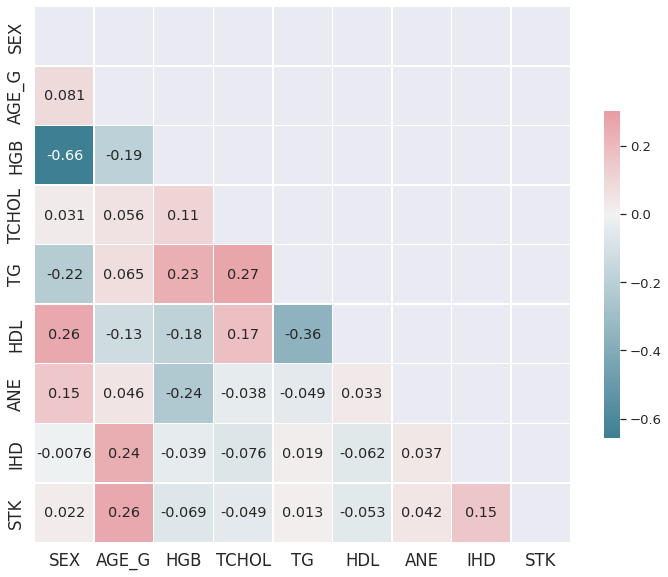

In [ ]:
corr = df.corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

sns.set(font_scale=1.2)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

## DNN 모델 훈련 및 예측

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Create np arrays for both the labels and features
y_train = np.array(train_df.pop('IHD'))
y_val = np.array(val_df.pop('IHD'))
y_test = np.array(test_df.pop('IHD'))

X_train = np.array(train_df)
X_val = np.array(val_df)
X_test = np.array(test_df)

In [ ]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
print('y_train shape:', y_train.shape)
print('y_val shape:', y_val.shape)
print('y_test shape:', y_test.shape)

print()

print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)

y_train shape: (640000,)
y_val shape: (160000,)
y_test shape: (200000,)

X_train shape: (640000, 8)
X_val shape: (160000, 8)
X_test shape: (200000, 8)


In [ ]:
METRICS = [
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]

In [ ]:
def make_model(metrics=METRICS):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu',
                           input_shape=(X_train.shape[-1],)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(.1),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

In [ ]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    verbose=1,
    patience=15,
    mode='max',
    restore_best_weights=True)

In [ ]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                576       
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 25,537
Trainable params: 25,537
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val))

Epoch 1/100
313/313 [==============================] - 18s 45ms/step - loss: 0.2397 - accuracy: 0.9259 - precision: 0.0749 - recall: 0.0053 - auc: 0.7287 - val_loss: 0.2191 - val_accuracy: 0.9294 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7873
Epoch 2/100
313/313 [==============================] - 6s 19ms/step - loss: 0.2170 - accuracy: 0.9301 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7877 - val_loss: 0.2179 - val_accuracy: 0.9294 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7905
Epoch 3/100
313/313 [==============================] - 7s 22ms/step - loss: 0.2163 - accuracy: 0.9301 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7893 - val_loss: 0.2172 - val_accuracy: 0.9294 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7915
Epoch 4/100
313/313 [==============================] - 6s 19ms/step - loss: 0.2159 - accuracy: 0.9301 - precision: 0.2000 - recall: 2.2350e-05 - auc: 0.7907 - val_loss: 0.2166 - val_acc

In [ ]:
train_predictions = model.predict(X_train, batch_size=BATCH_SIZE)
test_predictions = model.predict(X_test, batch_size=BATCH_SIZE)

98/98 [==============================] - 1s 5ms/step


In [ ]:
test_predictions

array([[0.02712705],
       [0.02148276],
       [0.025061  ],
       ...,
       [0.01246691],
       [0.04532046],
       [0.06704235]], dtype=float32)

In [ ]:
def plot_metrics(history):
    metrics = ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history. epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history. epoch, history.history['val_'+metric],
                 color=colors[1], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, 1])
        elif metric == 'auc':
            plt.ylim([0.2,1])
        else:
            plt.ylim([0,1])

        plt.legend()

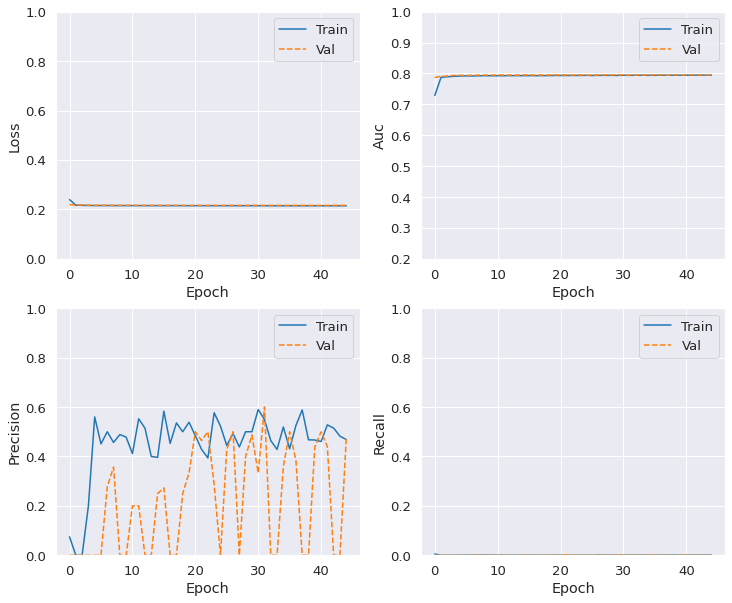

In [ ]:
plot_metrics(history)

In [ ]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('True Negatives: ', cm[0][0])
    print('False Positives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('True Positives: ', cm[1][1])

loss:  0.2160
accuracy:  0.9299
precision:  0.5000
recall:  0.0029
auc:  0.7937

True Negatives:  185935
False Positives:  40
False Negatives:  13985
True Positives:  40


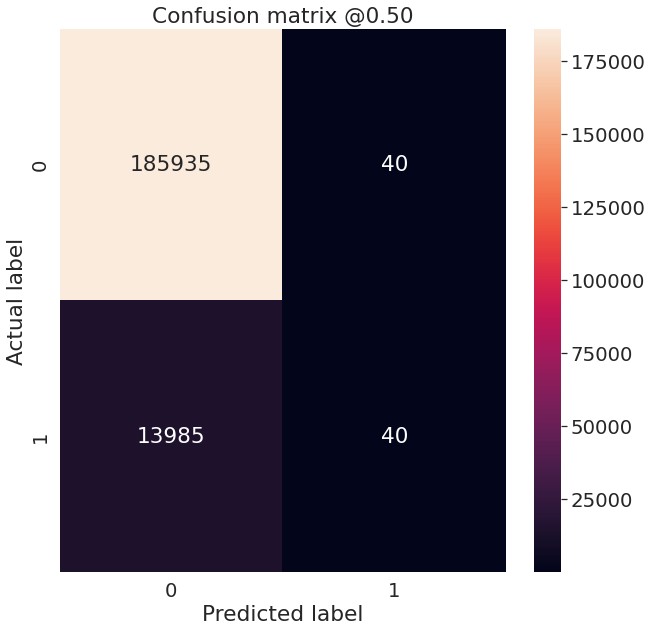

In [ ]:
results = model.evaluate(X_test, y_test,
                        batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, results):
    print(f'{name}:  {value:.4f}')
print()

sns.set(font_scale=1.8)
plot_cm(y_test, test_predictions)

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

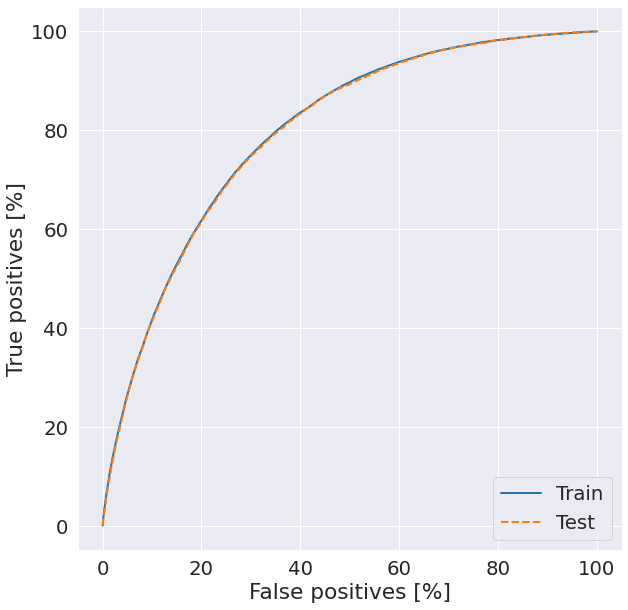

In [ ]:
plot_roc("Train", y_train, train_predictions, color=colors[0])
plot_roc("Test", y_test, test_predictions, color=colors[1], linestyle='--')
plt.legend(loc='lower right');